In [1]:
### import libraries
import torch
import torch.nn as nn
import numpy as np
import sys
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

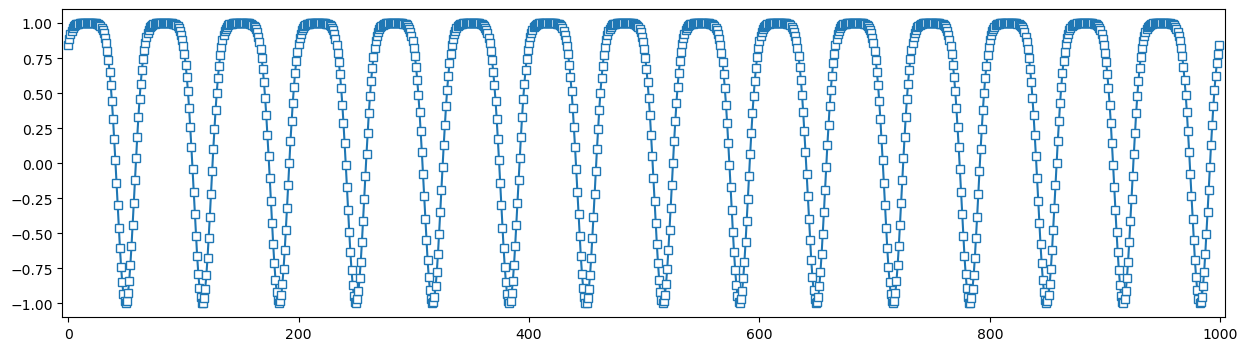

In [8]:
# import the data
N = 1000

time = torch.linspace(0, 30 * np.pi, N)
data = torch.sin(time+torch.cos(time))

plt.figure(figsize=(15,4))
plt.plot(data,'s-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

In [10]:
class Model(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        self.rnn = nn.RNN(input_size, num_hidden, num_layers)
        self.out = nn.Linear(num_hidden, 1)
    
    def forward(self, x, h):
        y, hidden = self.rnn(x,h)
        y = self.out(y)
        return y, hidden.detach()

In [13]:
input_size = 1
num_hidden = 9
num_layers = 1
seq_length = 30
batch_size = 1

model = Model(input_size=input_size,
              num_hidden=num_hidden,
              num_layers=num_layers)

X = torch.rand(seq_length, batch_size, input_size)
y, h = model(X, None)

X.shape, y.shape, h.shape

(torch.Size([30, 1, 1]), torch.Size([30, 1, 1]), torch.Size([1, 1, 9]))

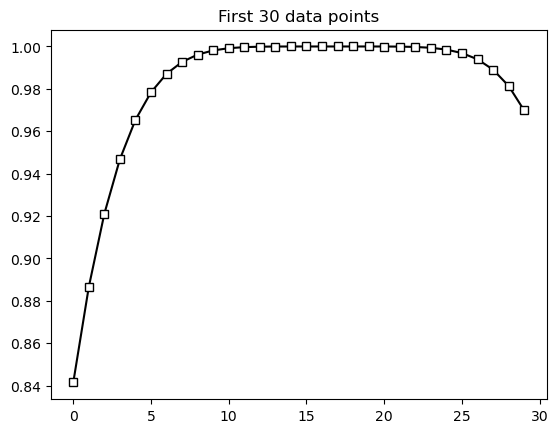

In [14]:
# is it enough data?

plt.plot(data[:seq_length],'ks-',markerfacecolor='w')
plt.title(f'First {seq_length} data points')
plt.show()

In [16]:
# test the model with some data
somedata = data[:seq_length].view(seq_length,1,1)
y = model(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

loss_fun = nn.MSELoss()
loss_fun(finalValue,data[seq_length].view(1,1))

tensor(0.2826, grad_fn=<MseLossBackward0>)

In [22]:
EPOCHS = 20

model = Model(input_size=input_size,
              num_hidden=num_hidden,
              num_layers=num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=.001)

losses = np.zeros(EPOCHS)
accuracies = np.zeros(EPOCHS)

for i in range(EPOCHS):

    seq_losses = []
    seq_acc = []
    hidden_state = None
    
    for j in range(N - seq_length):
        X = data[i:i+seq_length].view(seq_length,1,1)
        y = data[i+seq_length].view(1,1)

        y_hat, hiddenstate = model(X, hidden_state)
        final_value = y_hat[-1]
        loss = loss_fun(final_value, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        seq_losses.append(loss.item())

    losses[i] = np.mean(seq_losses)

    print(f"Epoch: {i+1} of {EPOCHS} | loss: {losses[i]}")


Epoch: 1 of 20 | loss: 0.00886192705817879
Epoch: 2 of 20 | loss: 2.5632609177455847e-06
Epoch: 3 of 20 | loss: 4.084306478292991e-06
Epoch: 4 of 20 | loss: 6.587716886874085e-06
Epoch: 5 of 20 | loss: 1.0383639437562641e-05
Epoch: 6 of 20 | loss: 1.5820541735941968e-05
Epoch: 7 of 20 | loss: 2.321154424815223e-05
Epoch: 8 of 20 | loss: 3.318821918045091e-05
Epoch: 9 of 20 | loss: 4.749315914196381e-05
Epoch: 10 of 20 | loss: 6.576429676946227e-05
Epoch: 11 of 20 | loss: 8.566712355450573e-05
Epoch: 12 of 20 | loss: 0.00010946380100964345
Epoch: 13 of 20 | loss: 0.00013250364387978392
Epoch: 14 of 20 | loss: 0.0001339357656743685
Epoch: 15 of 20 | loss: 0.00012376458103235635
Epoch: 16 of 20 | loss: 0.00010279638041474251
Epoch: 17 of 20 | loss: 7.946260086308187e-05
Epoch: 18 of 20 | loss: 5.401392658841706e-05
Epoch: 19 of 20 | loss: 3.055032942501977e-05
Epoch: 20 of 20 | loss: 1.1830707197821225e-05


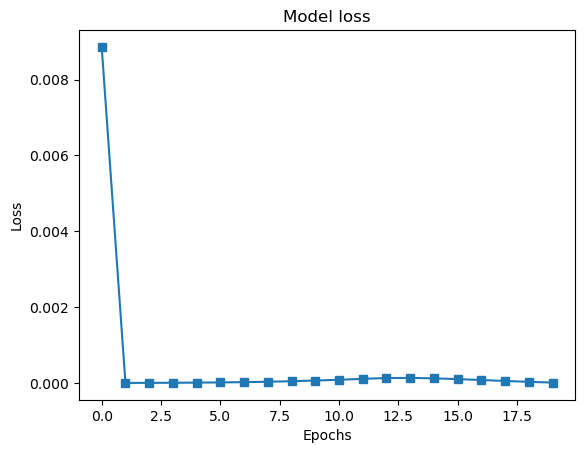

In [23]:
plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

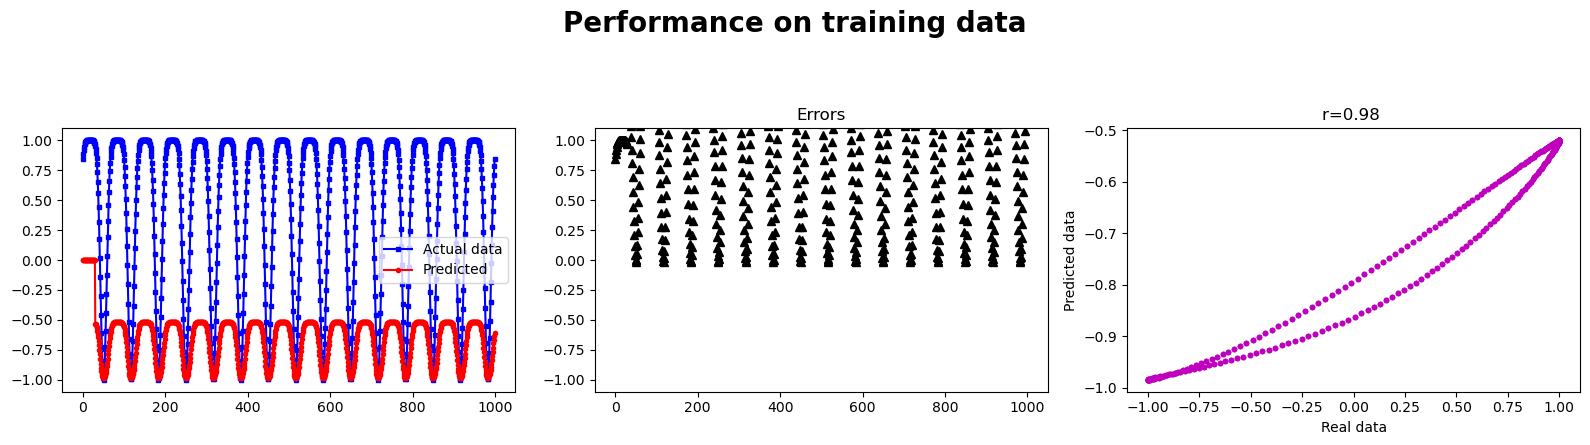

In [25]:
# now test the network!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None
for timei in range(N-seq_length):
  X = data[timei:timei+seq_length].view(seq_length,1,1)
  yy,hh = model(X,hh)
  yHat[timei+seq_length] = yy[-1]
  h[timei+seq_length,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seq_length:],yHat[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seq_length:],yHat[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} ")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()